In [1]:
import tensorflow as tf
import os, sys
import numpy as np
from matplotlib import pyplot as plt
layers = tf.contrib.layers

In [2]:
data_generator = os.environ['DATA_GENERATOR']
sys.path.append(data_generator)
import get_data
from visualization import Visualizer

autoencoder

In [3]:
#     def _build_graph(self, input, dim_code, reuse=tf.AUTO_REUSE, training=False):
#         regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
#         net = layers.conv2d(input, 128, (3,3), 1, weights_regularizer=regularizer)
#         net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.flatten(net)
#         net = layers.fully_connected(net, dim_code, weights_regularizer=regularizer)
#         #net = layers.fully_connected(net, 7*7, weights_regularizer=regularizer)
#         net = tf.reshape(shape=[-1, 7, 7, 1], tensor=net)
#         net = layers.conv2d_transpose(net, 64, (3,3), 1, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 128, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 1, (3,3), 1, activation_fn=tf.nn.tanh, weights_regularizer=regularizer)
#         return net

variational autoencoder

In [4]:
#     def _build_graph(self, input, dim_code, reuse=tf.AUTO_REUSE, training=False):
#         regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
#         net = layers.conv2d(input, 128, (3,3), 1, weights_regularizer=regularizer)
#         net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.flatten(net)
        
#         z_mu = layers.fully_connected(net, dim_code, weights_regularizer=regularizer)
#         z_logvar = layers.fully_connected(net, dim_code, weights_regularizer=regularizer)
#         epsilon = tf.random_normal(tf.shape(z_logvar), name='epsilon')
#         z_std = tf.sqrt(tf.exp(z_logvar))
#         latent_var = z_mu + epsilon*z_std
        
#         net = layers.fully_connected(latent_var, 7*7, weights_regularizer=regularizer)
#         net = tf.reshape(shape=[-1, 7, 7, 1], tensor=net)
#         net = layers.conv2d_transpose(net, 64, (3,3), 1, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 64, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 128, (3,3), 2, weights_regularizer=regularizer)
#         net = layers.conv2d_transpose(net, 1, (3,3), 1, activation_fn=tf.nn.tanh, weights_regularizer=regularizer)
#         return net

In [5]:
class VAE():
    def __init__(self):
        self.graph = tf.Graph()
        self.batch_size = 128
        with self.graph.as_default():
            with tf.device('/cpu:0'):
                self.images, labels = get_data.data_pipeline('mnist', 128, 'train')
            self.visualizer = Visualizer(exp_name='VAE_mnist+batch_norm', row=8, col=8)
            self.generated_images, z_mu, z_std = self._build_graph(self.images, 8, reuse=tf.AUTO_REUSE, training=True)
            self.recon_loss = self._recon_loss_function(self.images, self.generated_images)
            self.kld_loss = self._kld_loss_function(z_mu, z_std)
            self.loss = tf.reduce_mean(self.recon_loss + self.kld_loss)
            self.solver = tf.train.AdamOptimizer(learning_rate=0.0001) \
                           .minimize(self.loss)
            initializer = tf.global_variables_initializer()
            self.sess = tf.Session()
            self.sess.run(initializer)
    def train(self, iteration):
        for i in range(iteration+1):
            loss, recon_loss, kld_loss, _, np_real_images, np_generated_images = self.sess.run(
                    [self.loss, self.recon_loss, self.kld_loss, self.solver, self.images, self.generated_images])
            if i % 10 == 0:
                print("iterator {} : loss {:.3} = kld {:.3} + recon {:.3} ".format(i, loss, kld_loss, recon_loss))
            if i % 1000 == 0:
                self.visualize(np_real_images, np_generated_images, i)
            
    def visualize(self, images, generated_images, i):
        visual_imgs = np.concatenate( (images[:8*4], generated_images[:8*4]), axis = 0 )
        visual_imgs = 255*(visual_imgs/2 + 0.5)
        visual_imgs = visual_imgs.astype(int)
        self.visualizer.draw_imgs(visual_imgs)
        self.visualizer.save_fig(name="VAE_mnist_iter_{}".format(str(i)))
        
    def _build_graph(self, input, dim_code, reuse=tf.AUTO_REUSE, training=False):
        regularizer = layers.l2_regularizer(scale=0.1)
        normalizer = layers.batch_norm
        net = layers.conv2d(input, 64, (3,3), 1, weights_regularizer=regularizer, normalizer_fn=normalizer)
        net = layers.conv2d(net, 32, (3,3), 2, weights_regularizer=regularizer, normalizer_fn=normalizer)
        net = layers.conv2d(net, 32, (3,3), 2, weights_regularizer=regularizer, normalizer_fn=normalizer)
        net = layers.flatten(net)
        net = layers.fully_connected(net, 128, weights_regularizer=regularizer, normalizer_fn=normalizer)
        z_mu = layers.fully_connected(net, dim_code, weights_regularizer=regularizer, normalizer_fn=normalizer)
        z_logvar = layers.fully_connected(net, dim_code, weights_regularizer=regularizer, normalizer_fn=normalizer)
        epsilon = tf.random_normal(tf.shape(z_logvar), name='epsilon')
        z_std = tf.sqrt(tf.exp(z_logvar))
        latent_var = z_mu + epsilon*z_std
        net = layers.fully_connected(latent_var, 128, weights_regularizer=regularizer, normalizer_fn=normalizer)
        net = layers.fully_connected(net, 7*7*32, weights_regularizer=regularizer, normalizer_fn=normalizer)
        net = tf.reshape(shape=[-1, 7, 7, 32], tensor=net)
        net = layers.conv2d_transpose(net, 32, (3,3), 1, weights_regularizer=regularizer, normalizer_fn=normalizer)
        net = layers.conv2d_transpose(net, 64, (3,3), 2, weights_regularizer=regularizer, normalizer_fn=normalizer)
        net = layers.conv2d_transpose(net, 64, (3,3), 2, weights_regularizer=regularizer, normalizer_fn=normalizer)
        net = layers.conv2d_transpose(net, 1, (3,3), 1, activation_fn=tf.nn.tanh, weights_regularizer=regularizer)
        return net, z_mu, z_std
    def _recon_loss_function(self, _real_images, _generated_images):
        recon_loss = tf.reduce_sum(tf.square(_real_images - _generated_images))
        return recon_loss
    def _kld_loss_function(self, z_mu, z_std):
        #KLD_loss = -0.5 * tf.reduce_mean(1 + z_std - tf.pow(z_mu, 2) - tf.exp(z_std))
        KLD_loss = -0.5 * tf.reduce_sum(1 -tf.square(z_mu) -tf.square(z_std) + tf.log(1e-8 + tf.square(z_std)))
        return KLD_loss
    def close(self):
        self.sess.close()

(?, 28, 28, 1)


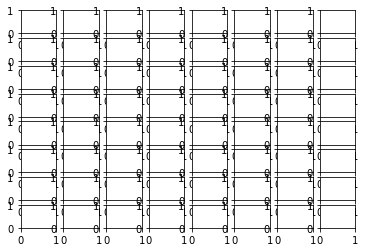

In [6]:
x = VAE()

In [7]:
x.train(iteration=20000)
x.close()

iterator 0 : loss 1.21e+05 = kld 4.93e+02 + recon 1.21e+05 
iterator 10 : loss 8.09e+04 = kld 5.29e+02 + recon 8.03e+04 
iterator 20 : loss 5.98e+04 = kld 5.24e+02 + recon 5.93e+04 
iterator 30 : loss 4.8e+04 = kld 5.24e+02 + recon 4.74e+04 
iterator 40 : loss 4.24e+04 = kld 6.21e+02 + recon 4.18e+04 
iterator 50 : loss 3.9e+04 = kld 5.81e+02 + recon 3.84e+04 
iterator 60 : loss 3.59e+04 = kld 6.6e+02 + recon 3.53e+04 
iterator 70 : loss 3.66e+04 = kld 6.68e+02 + recon 3.59e+04 
iterator 80 : loss 3.34e+04 = kld 6.45e+02 + recon 3.28e+04 
iterator 90 : loss 3.49e+04 = kld 6.03e+02 + recon 3.43e+04 
iterator 100 : loss 3.42e+04 = kld 5.77e+02 + recon 3.36e+04 
iterator 110 : loss 3.12e+04 = kld 6.7e+02 + recon 3.05e+04 
iterator 120 : loss 2.96e+04 = kld 6.1e+02 + recon 2.89e+04 
iterator 130 : loss 3.04e+04 = kld 5.98e+02 + recon 2.98e+04 
iterator 140 : loss 2.92e+04 = kld 7.83e+02 + recon 2.84e+04 
iterator 150 : loss 3.22e+04 = kld 6.37e+02 + recon 3.16e+04 
iterator 160 : loss 2.98

iterator 1330 : loss 2.17e+04 = kld 8.16e+02 + recon 2.09e+04 
iterator 1340 : loss 2.03e+04 = kld 8.74e+02 + recon 1.94e+04 
iterator 1350 : loss 2.04e+04 = kld 8.05e+02 + recon 1.96e+04 
iterator 1360 : loss 2.07e+04 = kld 8.11e+02 + recon 1.99e+04 
iterator 1370 : loss 2.11e+04 = kld 7.68e+02 + recon 2.03e+04 
iterator 1380 : loss 2.09e+04 = kld 8.24e+02 + recon 2.01e+04 
iterator 1390 : loss 2.07e+04 = kld 8.05e+02 + recon 1.99e+04 
iterator 1400 : loss 2.25e+04 = kld 7.98e+02 + recon 2.17e+04 
iterator 1410 : loss 2.04e+04 = kld 8.27e+02 + recon 1.96e+04 
iterator 1420 : loss 2.08e+04 = kld 8.88e+02 + recon 1.99e+04 
iterator 1430 : loss 2.04e+04 = kld 8.8e+02 + recon 1.95e+04 
iterator 1440 : loss 2.35e+04 = kld 8.42e+02 + recon 2.27e+04 
iterator 1450 : loss 2.37e+04 = kld 8.34e+02 + recon 2.28e+04 
iterator 1460 : loss 2.07e+04 = kld 8.15e+02 + recon 1.99e+04 
iterator 1470 : loss 2.25e+04 = kld 8.32e+02 + recon 2.17e+04 
iterator 1480 : loss 2.15e+04 = kld 8.08e+02 + recon 2.0

iterator 2640 : loss 1.95e+04 = kld 8.62e+02 + recon 1.87e+04 
iterator 2650 : loss 2.08e+04 = kld 9.16e+02 + recon 1.99e+04 
iterator 2660 : loss 2.05e+04 = kld 8.51e+02 + recon 1.96e+04 
iterator 2670 : loss 2.14e+04 = kld 8.2e+02 + recon 2.06e+04 
iterator 2680 : loss 2.05e+04 = kld 8.72e+02 + recon 1.96e+04 
iterator 2690 : loss 1.96e+04 = kld 8.74e+02 + recon 1.87e+04 
iterator 2700 : loss 2.08e+04 = kld 8.38e+02 + recon 1.99e+04 
iterator 2710 : loss 2.07e+04 = kld 8.78e+02 + recon 1.98e+04 
iterator 2720 : loss 2.11e+04 = kld 8.59e+02 + recon 2.03e+04 
iterator 2730 : loss 2.07e+04 = kld 9.11e+02 + recon 1.98e+04 
iterator 2740 : loss 2.09e+04 = kld 8.38e+02 + recon 2.01e+04 
iterator 2750 : loss 1.97e+04 = kld 8.53e+02 + recon 1.88e+04 
iterator 2760 : loss 1.97e+04 = kld 8.92e+02 + recon 1.88e+04 
iterator 2770 : loss 2.16e+04 = kld 8.63e+02 + recon 2.07e+04 
iterator 2780 : loss 1.95e+04 = kld 8.79e+02 + recon 1.86e+04 
iterator 2790 : loss 1.99e+04 = kld 8.93e+02 + recon 1.9

iterator 3970 : loss 2e+04 = kld 9.11e+02 + recon 1.91e+04 
iterator 3980 : loss 1.89e+04 = kld 8.91e+02 + recon 1.8e+04 
iterator 3990 : loss 1.83e+04 = kld 9.24e+02 + recon 1.74e+04 
iterator 4000 : loss 1.99e+04 = kld 8.56e+02 + recon 1.91e+04 
iterator 4010 : loss 1.84e+04 = kld 8.76e+02 + recon 1.75e+04 
iterator 4020 : loss 2.09e+04 = kld 9.17e+02 + recon 2e+04 
iterator 4030 : loss 2.07e+04 = kld 8.84e+02 + recon 1.98e+04 
iterator 4040 : loss 2.04e+04 = kld 9.1e+02 + recon 1.94e+04 
iterator 4050 : loss 2.04e+04 = kld 8.52e+02 + recon 1.96e+04 
iterator 4060 : loss 1.99e+04 = kld 8.68e+02 + recon 1.9e+04 
iterator 4070 : loss 1.98e+04 = kld 9.27e+02 + recon 1.89e+04 
iterator 4080 : loss 2.18e+04 = kld 9.29e+02 + recon 2.08e+04 
iterator 4090 : loss 1.9e+04 = kld 9.14e+02 + recon 1.81e+04 
iterator 4100 : loss 2e+04 = kld 9.41e+02 + recon 1.91e+04 
iterator 4110 : loss 2.08e+04 = kld 8.44e+02 + recon 1.99e+04 
iterator 4120 : loss 2.11e+04 = kld 8.85e+02 + recon 2.02e+04 
itera

iterator 5310 : loss 2.13e+04 = kld 9.44e+02 + recon 2.03e+04 
iterator 5320 : loss 1.95e+04 = kld 8.87e+02 + recon 1.86e+04 
iterator 5330 : loss 2.04e+04 = kld 9.19e+02 + recon 1.95e+04 
iterator 5340 : loss 1.93e+04 = kld 8.79e+02 + recon 1.84e+04 
iterator 5350 : loss 1.91e+04 = kld 8.9e+02 + recon 1.83e+04 
iterator 5360 : loss 1.92e+04 = kld 9.39e+02 + recon 1.83e+04 
iterator 5370 : loss 1.99e+04 = kld 8.62e+02 + recon 1.9e+04 
iterator 5380 : loss 2.05e+04 = kld 9.05e+02 + recon 1.96e+04 
iterator 5390 : loss 1.99e+04 = kld 9.14e+02 + recon 1.9e+04 
iterator 5400 : loss 1.95e+04 = kld 8.73e+02 + recon 1.86e+04 
iterator 5410 : loss 1.99e+04 = kld 9.08e+02 + recon 1.9e+04 
iterator 5420 : loss 1.84e+04 = kld 9.08e+02 + recon 1.75e+04 
iterator 5430 : loss 1.95e+04 = kld 9.68e+02 + recon 1.85e+04 
iterator 5440 : loss 2.17e+04 = kld 9.07e+02 + recon 2.08e+04 
iterator 5450 : loss 2.07e+04 = kld 9.13e+02 + recon 1.98e+04 
iterator 5460 : loss 1.96e+04 = kld 9.67e+02 + recon 1.86e+

iterator 6640 : loss 2.03e+04 = kld 9.79e+02 + recon 1.94e+04 
iterator 6650 : loss 1.9e+04 = kld 9.28e+02 + recon 1.8e+04 
iterator 6660 : loss 2.18e+04 = kld 9.8e+02 + recon 2.08e+04 
iterator 6670 : loss 2.13e+04 = kld 9.48e+02 + recon 2.04e+04 
iterator 6680 : loss 1.96e+04 = kld 9.67e+02 + recon 1.86e+04 
iterator 6690 : loss 1.98e+04 = kld 9.01e+02 + recon 1.89e+04 
iterator 6700 : loss 1.84e+04 = kld 9.38e+02 + recon 1.75e+04 
iterator 6710 : loss 1.97e+04 = kld 9.5e+02 + recon 1.87e+04 
iterator 6720 : loss 1.89e+04 = kld 9.15e+02 + recon 1.8e+04 
iterator 6730 : loss 1.97e+04 = kld 8.91e+02 + recon 1.88e+04 
iterator 6740 : loss 2.01e+04 = kld 9.29e+02 + recon 1.92e+04 
iterator 6750 : loss 2.09e+04 = kld 9.35e+02 + recon 1.99e+04 
iterator 6760 : loss 1.9e+04 = kld 9.15e+02 + recon 1.81e+04 
iterator 6770 : loss 1.87e+04 = kld 9.05e+02 + recon 1.78e+04 
iterator 6780 : loss 1.92e+04 = kld 9.55e+02 + recon 1.82e+04 
iterator 6790 : loss 1.93e+04 = kld 9.23e+02 + recon 1.84e+04

iterator 7970 : loss 1.87e+04 = kld 9.56e+02 + recon 1.77e+04 
iterator 7980 : loss 1.9e+04 = kld 9.83e+02 + recon 1.8e+04 
iterator 7990 : loss 1.82e+04 = kld 9.6e+02 + recon 1.73e+04 
iterator 8000 : loss 1.92e+04 = kld 9.62e+02 + recon 1.82e+04 
iterator 8010 : loss 1.93e+04 = kld 9.25e+02 + recon 1.84e+04 
iterator 8020 : loss 1.99e+04 = kld 9.55e+02 + recon 1.89e+04 
iterator 8030 : loss 1.88e+04 = kld 9.43e+02 + recon 1.78e+04 
iterator 8040 : loss 2.08e+04 = kld 9.25e+02 + recon 1.99e+04 
iterator 8050 : loss 1.87e+04 = kld 9.33e+02 + recon 1.78e+04 
iterator 8060 : loss 1.85e+04 = kld 9.46e+02 + recon 1.76e+04 
iterator 8070 : loss 2.1e+04 = kld 9.69e+02 + recon 2e+04 
iterator 8080 : loss 2.14e+04 = kld 9.41e+02 + recon 2.04e+04 
iterator 8090 : loss 1.8e+04 = kld 9.35e+02 + recon 1.71e+04 
iterator 8100 : loss 2.02e+04 = kld 9.35e+02 + recon 1.93e+04 
iterator 8110 : loss 1.8e+04 = kld 9.74e+02 + recon 1.7e+04 
iterator 8120 : loss 2.08e+04 = kld 9.47e+02 + recon 1.99e+04 
it

iterator 9280 : loss 2.04e+04 = kld 9.34e+02 + recon 1.95e+04 
iterator 9290 : loss 1.98e+04 = kld 9.33e+02 + recon 1.88e+04 
iterator 9300 : loss 1.88e+04 = kld 9.05e+02 + recon 1.78e+04 
iterator 9310 : loss 1.96e+04 = kld 1.01e+03 + recon 1.85e+04 
iterator 9320 : loss 1.86e+04 = kld 9.43e+02 + recon 1.76e+04 
iterator 9330 : loss 1.87e+04 = kld 9.2e+02 + recon 1.78e+04 
iterator 9340 : loss 1.92e+04 = kld 9.59e+02 + recon 1.83e+04 
iterator 9350 : loss 1.9e+04 = kld 9.51e+02 + recon 1.81e+04 
iterator 9360 : loss 1.85e+04 = kld 9.62e+02 + recon 1.76e+04 
iterator 9370 : loss 1.99e+04 = kld 9.23e+02 + recon 1.9e+04 
iterator 9380 : loss 1.86e+04 = kld 1.03e+03 + recon 1.76e+04 
iterator 9390 : loss 1.89e+04 = kld 9.33e+02 + recon 1.8e+04 
iterator 9400 : loss 1.9e+04 = kld 9.31e+02 + recon 1.81e+04 
iterator 9410 : loss 1.92e+04 = kld 9.62e+02 + recon 1.83e+04 
iterator 9420 : loss 1.92e+04 = kld 9.67e+02 + recon 1.82e+04 
iterator 9430 : loss 1.85e+04 = kld 1.01e+03 + recon 1.75e+0

iterator 10580 : loss 1.91e+04 = kld 9.41e+02 + recon 1.81e+04 
iterator 10590 : loss 1.86e+04 = kld 9.76e+02 + recon 1.76e+04 
iterator 10600 : loss 1.99e+04 = kld 9.59e+02 + recon 1.89e+04 
iterator 10610 : loss 1.85e+04 = kld 9.63e+02 + recon 1.76e+04 
iterator 10620 : loss 1.89e+04 = kld 9.53e+02 + recon 1.79e+04 
iterator 10630 : loss 1.92e+04 = kld 9.6e+02 + recon 1.83e+04 
iterator 10640 : loss 1.95e+04 = kld 9.61e+02 + recon 1.85e+04 
iterator 10650 : loss 1.87e+04 = kld 9.44e+02 + recon 1.78e+04 
iterator 10660 : loss 1.9e+04 = kld 9.91e+02 + recon 1.8e+04 
iterator 10670 : loss 1.94e+04 = kld 9.8e+02 + recon 1.84e+04 
iterator 10680 : loss 1.95e+04 = kld 9.8e+02 + recon 1.85e+04 
iterator 10690 : loss 2.01e+04 = kld 9.69e+02 + recon 1.92e+04 
iterator 10700 : loss 1.91e+04 = kld 9.6e+02 + recon 1.82e+04 
iterator 10710 : loss 1.83e+04 = kld 9.94e+02 + recon 1.73e+04 
iterator 10720 : loss 1.73e+04 = kld 9.89e+02 + recon 1.64e+04 
iterator 10730 : loss 1.81e+04 = kld 9.69e+02 

iterator 11880 : loss 1.93e+04 = kld 9.83e+02 + recon 1.83e+04 
iterator 11890 : loss 1.89e+04 = kld 9.27e+02 + recon 1.8e+04 
iterator 11900 : loss 1.87e+04 = kld 9.56e+02 + recon 1.77e+04 
iterator 11910 : loss 1.84e+04 = kld 9.61e+02 + recon 1.75e+04 
iterator 11920 : loss 1.88e+04 = kld 9.22e+02 + recon 1.79e+04 
iterator 11930 : loss 1.86e+04 = kld 9.53e+02 + recon 1.77e+04 
iterator 11940 : loss 1.86e+04 = kld 9.62e+02 + recon 1.77e+04 
iterator 11950 : loss 1.89e+04 = kld 9.44e+02 + recon 1.8e+04 
iterator 11960 : loss 1.82e+04 = kld 9.44e+02 + recon 1.73e+04 
iterator 11970 : loss 1.92e+04 = kld 9.7e+02 + recon 1.82e+04 
iterator 11980 : loss 1.85e+04 = kld 9.66e+02 + recon 1.75e+04 
iterator 11990 : loss 1.82e+04 = kld 9.84e+02 + recon 1.72e+04 
iterator 12000 : loss 1.92e+04 = kld 9.48e+02 + recon 1.83e+04 
iterator 12010 : loss 1.97e+04 = kld 9.98e+02 + recon 1.87e+04 
iterator 12020 : loss 1.8e+04 = kld 9.47e+02 + recon 1.71e+04 
iterator 12030 : loss 1.84e+04 = kld 9.72e+0

iterator 13190 : loss 1.98e+04 = kld 9.81e+02 + recon 1.88e+04 
iterator 13200 : loss 1.95e+04 = kld 9.63e+02 + recon 1.86e+04 
iterator 13210 : loss 1.85e+04 = kld 1.01e+03 + recon 1.75e+04 
iterator 13220 : loss 1.92e+04 = kld 9.83e+02 + recon 1.83e+04 
iterator 13230 : loss 1.87e+04 = kld 1.01e+03 + recon 1.77e+04 
iterator 13240 : loss 1.81e+04 = kld 9.55e+02 + recon 1.71e+04 
iterator 13250 : loss 1.87e+04 = kld 9.81e+02 + recon 1.77e+04 
iterator 13260 : loss 1.87e+04 = kld 9.6e+02 + recon 1.77e+04 
iterator 13270 : loss 1.84e+04 = kld 9.6e+02 + recon 1.75e+04 
iterator 13280 : loss 2.11e+04 = kld 9.69e+02 + recon 2.01e+04 
iterator 13290 : loss 1.86e+04 = kld 9.84e+02 + recon 1.76e+04 
iterator 13300 : loss 2.04e+04 = kld 9.9e+02 + recon 1.94e+04 
iterator 13310 : loss 2.01e+04 = kld 9.53e+02 + recon 1.91e+04 
iterator 13320 : loss 1.98e+04 = kld 9.38e+02 + recon 1.89e+04 
iterator 13330 : loss 1.83e+04 = kld 9.53e+02 + recon 1.74e+04 
iterator 13340 : loss 1.83e+04 = kld 9.47e+

iterator 14480 : loss 1.92e+04 = kld 9.64e+02 + recon 1.82e+04 
iterator 14490 : loss 1.93e+04 = kld 9.52e+02 + recon 1.83e+04 
iterator 14500 : loss 1.76e+04 = kld 9.69e+02 + recon 1.66e+04 
iterator 14510 : loss 1.83e+04 = kld 9.97e+02 + recon 1.73e+04 
iterator 14520 : loss 1.75e+04 = kld 9.81e+02 + recon 1.66e+04 
iterator 14530 : loss 1.91e+04 = kld 1.02e+03 + recon 1.81e+04 
iterator 14540 : loss 1.94e+04 = kld 1.02e+03 + recon 1.84e+04 
iterator 14550 : loss 1.91e+04 = kld 9.68e+02 + recon 1.82e+04 
iterator 14560 : loss 1.78e+04 = kld 9.75e+02 + recon 1.69e+04 
iterator 14570 : loss 1.89e+04 = kld 9.72e+02 + recon 1.79e+04 
iterator 14580 : loss 1.88e+04 = kld 1.08e+03 + recon 1.77e+04 
iterator 14590 : loss 1.93e+04 = kld 9.44e+02 + recon 1.84e+04 
iterator 14600 : loss 1.93e+04 = kld 1.05e+03 + recon 1.83e+04 
iterator 14610 : loss 1.82e+04 = kld 9.62e+02 + recon 1.73e+04 
iterator 14620 : loss 1.75e+04 = kld 9.77e+02 + recon 1.66e+04 
iterator 14630 : loss 2.06e+04 = kld 9.8

iterator 15780 : loss 1.81e+04 = kld 9.25e+02 + recon 1.72e+04 
iterator 15790 : loss 1.9e+04 = kld 9.56e+02 + recon 1.8e+04 
iterator 15800 : loss 1.89e+04 = kld 9.96e+02 + recon 1.79e+04 
iterator 15810 : loss 1.85e+04 = kld 1.01e+03 + recon 1.75e+04 
iterator 15820 : loss 1.91e+04 = kld 9.6e+02 + recon 1.81e+04 
iterator 15830 : loss 1.98e+04 = kld 9.62e+02 + recon 1.89e+04 
iterator 15840 : loss 2.03e+04 = kld 9.68e+02 + recon 1.93e+04 
iterator 15850 : loss 1.98e+04 = kld 9.68e+02 + recon 1.89e+04 
iterator 15860 : loss 1.91e+04 = kld 9.6e+02 + recon 1.81e+04 
iterator 15870 : loss 1.82e+04 = kld 9.51e+02 + recon 1.73e+04 
iterator 15880 : loss 1.82e+04 = kld 9.59e+02 + recon 1.72e+04 
iterator 15890 : loss 1.88e+04 = kld 9.44e+02 + recon 1.78e+04 
iterator 15900 : loss 1.88e+04 = kld 1e+03 + recon 1.78e+04 
iterator 15910 : loss 1.83e+04 = kld 1.14e+03 + recon 1.71e+04 
iterator 15920 : loss 1.86e+04 = kld 9.7e+02 + recon 1.76e+04 
iterator 15930 : loss 2.17e+04 = kld 9.66e+02 + 

iterator 17070 : loss 1.98e+04 = kld 9.55e+02 + recon 1.89e+04 
iterator 17080 : loss 1.87e+04 = kld 9.69e+02 + recon 1.77e+04 
iterator 17090 : loss 1.85e+04 = kld 9.56e+02 + recon 1.75e+04 
iterator 17100 : loss 1.8e+04 = kld 9.73e+02 + recon 1.7e+04 
iterator 17110 : loss 1.79e+04 = kld 9.58e+02 + recon 1.7e+04 
iterator 17120 : loss 1.89e+04 = kld 9.48e+02 + recon 1.79e+04 
iterator 17130 : loss 1.79e+04 = kld 9.5e+02 + recon 1.7e+04 
iterator 17140 : loss 1.85e+04 = kld 9.49e+02 + recon 1.75e+04 
iterator 17150 : loss 1.89e+04 = kld 9.65e+02 + recon 1.79e+04 
iterator 17160 : loss 1.85e+04 = kld 9.5e+02 + recon 1.76e+04 
iterator 17170 : loss 1.84e+04 = kld 9.63e+02 + recon 1.74e+04 
iterator 17180 : loss 1.99e+04 = kld 9.57e+02 + recon 1.89e+04 
iterator 17190 : loss 1.73e+04 = kld 9.8e+02 + recon 1.63e+04 
iterator 17200 : loss 1.8e+04 = kld 9.55e+02 + recon 1.7e+04 
iterator 17210 : loss 1.89e+04 = kld 9.82e+02 + recon 1.79e+04 
iterator 17220 : loss 1.84e+04 = kld 1.01e+03 + r

iterator 18360 : loss 1.99e+04 = kld 9.57e+02 + recon 1.9e+04 
iterator 18370 : loss 1.82e+04 = kld 9.64e+02 + recon 1.72e+04 
iterator 18380 : loss 1.9e+04 = kld 9.66e+02 + recon 1.8e+04 
iterator 18390 : loss 2.04e+04 = kld 9.75e+02 + recon 1.94e+04 
iterator 18400 : loss 1.87e+04 = kld 9.59e+02 + recon 1.78e+04 
iterator 18410 : loss 1.88e+04 = kld 9.45e+02 + recon 1.79e+04 
iterator 18420 : loss 1.76e+04 = kld 9.89e+02 + recon 1.66e+04 
iterator 18430 : loss 2.01e+04 = kld 9.67e+02 + recon 1.92e+04 
iterator 18440 : loss 1.92e+04 = kld 9.58e+02 + recon 1.83e+04 
iterator 18450 : loss 1.98e+04 = kld 9.47e+02 + recon 1.88e+04 
iterator 18460 : loss 1.91e+04 = kld 9.52e+02 + recon 1.81e+04 
iterator 18470 : loss 1.77e+04 = kld 9.49e+02 + recon 1.67e+04 
iterator 18480 : loss 1.83e+04 = kld 1.01e+03 + recon 1.73e+04 
iterator 18490 : loss 1.84e+04 = kld 9.4e+02 + recon 1.75e+04 
iterator 18500 : loss 2.01e+04 = kld 9.34e+02 + recon 1.92e+04 
iterator 18510 : loss 1.94e+04 = kld 9.39e+0

iterator 19650 : loss 1.93e+04 = kld 9.5e+02 + recon 1.84e+04 
iterator 19660 : loss 1.83e+04 = kld 9.42e+02 + recon 1.74e+04 
iterator 19670 : loss 1.84e+04 = kld 9.62e+02 + recon 1.74e+04 
iterator 19680 : loss 2.06e+04 = kld 9.44e+02 + recon 1.96e+04 
iterator 19690 : loss 1.84e+04 = kld 9.79e+02 + recon 1.74e+04 
iterator 19700 : loss 1.97e+04 = kld 9.88e+02 + recon 1.87e+04 
iterator 19710 : loss 1.75e+04 = kld 9.89e+02 + recon 1.65e+04 
iterator 19720 : loss 1.87e+04 = kld 9.81e+02 + recon 1.77e+04 
iterator 19730 : loss 1.88e+04 = kld 1e+03 + recon 1.78e+04 
iterator 19740 : loss 1.75e+04 = kld 9.62e+02 + recon 1.65e+04 
iterator 19750 : loss 1.94e+04 = kld 9.67e+02 + recon 1.85e+04 
iterator 19760 : loss 1.86e+04 = kld 9.37e+02 + recon 1.76e+04 
iterator 19770 : loss 1.89e+04 = kld 9.64e+02 + recon 1.79e+04 
iterator 19780 : loss 1.94e+04 = kld 9.79e+02 + recon 1.84e+04 
iterator 19790 : loss 1.91e+04 = kld 9.63e+02 + recon 1.82e+04 
iterator 19800 : loss 1.9e+04 = kld 9.31e+02

https://github.com/dancsalo/TensorFlow-VAE